<font size="6">Генеративные модели</font>

# Общий взгляд на генеративные алгоритмы

## Задача генерации

Ранее мы в основном работали с **размеченными** данными. Мы научили нейронные сети решать задачи классификации, регрессии, сегментации и т. д. На входе модели у нас были исходные данные, по которым мы учились предсказывать целевые значения (метки классов, действительные числа, маски сегментации и т. д.):

$$\large \text{Входные данные} \xrightarrow[\text{}]{\text{Модель}} \text{Целевые значения}$$

Математически это можно записать так:

$$\large X \xrightarrow[\text{}]{f_{θ}(x)} Y ,$$
где $X$ — множество входных данных, $Y$ — множество целевых значений, $f_{θ}(x)$ — модель с настраиваемыми параметрами $θ$.

По сути наша модель — это сложная функция, которая ставит в соответствие каждому объекту $x$ из множества входных данных $X$ целевое значение $y$ из множества выходных данных $Y$:
$$\large y = f_{θ}(x)$$


С задачей генерации дела обстоят сложнее, ведь в задаче генерации мы хотим научить модель генерировать объекты, которых не было в исходной выборке.

**Постановка задачи генерации**

**Дано**: данные, часто неразмеченные.

**Результат генерации**: новые данные, которые будут удовлетворять следующим условиям:
* Новые данные **похожи** на исходные.
* Новые данные **не повторяют** исходные.

**Вход модели**: ❓

**Дополнительно:**
* Важен **элемент случайности**: результат генерации не повторяется при разных запусках.

Итого не очень понятно, **что должно подаваться на вход модели** и как обеспечить элемент случайности. В большинстве моделей генерации в качестве входных данных для модели используют **гауссовский или равномерный шум.**

$$\large \text{Шум} \xrightarrow[\text{}]{\text{Модель генерации}} \text{Сгенерированный объект}$$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/generator_model_pipeline.png" width="500"></center>



Математически это можно записать так:

$$\large Z \xrightarrow[\text{}]{g_{θ}(z)} X, $$
где $Z$ — хорошо изученное множество (например, нормальное гауссово распределение), из которого мы умеем семплировать объекты, $X$ — множество всех возможных объектов с неизвестным распределением или известным распределением, из которого мы не умеем семплировать.

По сути модель генерации — это сложная функция, которая ставит в соответствие объектам из известного распределения $z$ объекты из целевого распределения $x$:
$$\large x = g_{θ}(z)$$


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/generative_models.png" width="700"></center>

## Простейший пример: генерация объектов из нормального распределения

Чтобы обеспечить воспроизводимость примеров, зафиксируем начальные значения генераторов случайных чисел:

In [1]:
from IPython.display import clear_output

!pip install -q torchmetrics[image]
!pip install -q lightning==2.5.0 tbparse

clear_output()

In [2]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

Предположим, у нас под рукой есть генератор случайных чисел, который позволяет нам легко получить случайные числа в диапазоне $[0,1]$:

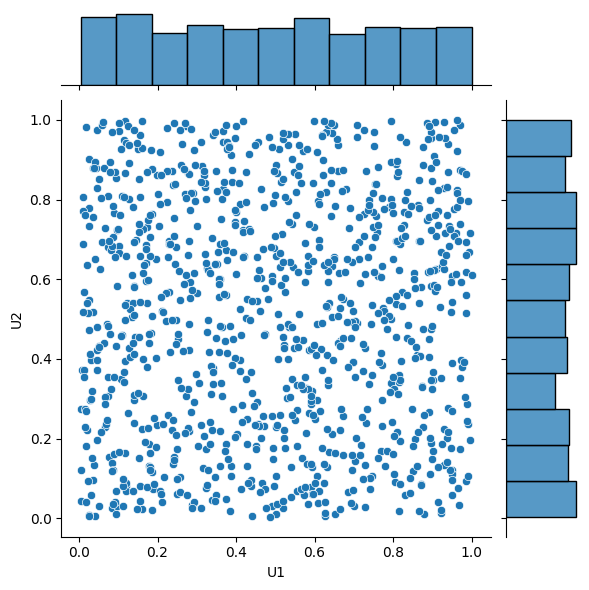

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

u1 = np.random.uniform(size=1000)
u2 = np.random.uniform(size=1000)

data = pd.DataFrame.from_dict(dict(zip(["U1", "U2"], [u1, u2])))

sns.jointplot(data=data, x="U1", y="U2")
plt.show()

Пусть $U_i$ — точка, которую даёт нам генератор равномерно распределенных случайных чисел. Если мы возьмём пару таких точек $U_1$, $U_2$ и произведём с ними так называемое [преобразование Бокса-Мюллера 📚[wiki]](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform), то получим пару новых точек $X$ и $Y$ на вещественной прямой:

$$
\begin{array}{l}
X=\sqrt{-2 \log U_{1}} \cos \left(2 \pi U_{2}\right) \\
Y=\sqrt{-2 \log U_{1}} \sin \left(2 \pi U_{2}\right)
\end{array}
$$

Повторив такую процедуру для большого числа точек $U_i$, можно заметить, что распределение для объектов $X$ и $Y$ становится похожим на стандартное нормальное:

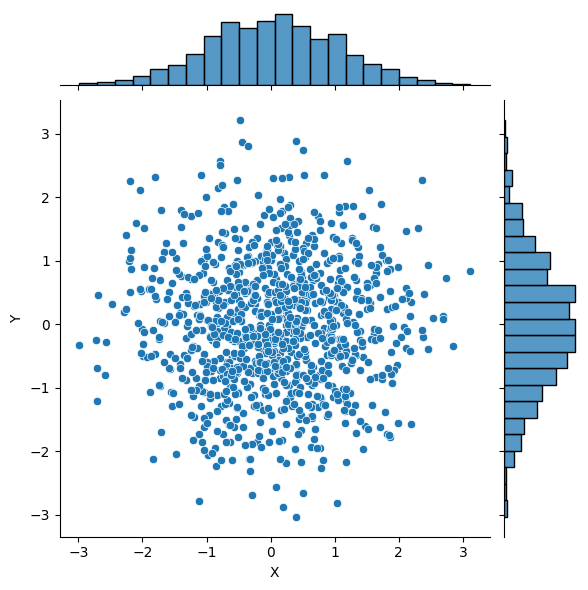

In [4]:
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2

x = r * np.cos(theta)
y = r * np.sin(theta)

data["X"] = x
data["Y"] = y

sns.jointplot(data=data, x="X", y="Y")
plt.show()

На самом деле мы можем в точности доказать, что преобразование Бокса-Мюллера преобразовало исходное равномерное распределение в стандартное нормальное
([доказательство 📚[book]](https://mathworld.wolfram.com/Box-MullerTransformation.html)).

Можно раскрасить точки выборки и посмотреть, как именно они преобразуются:

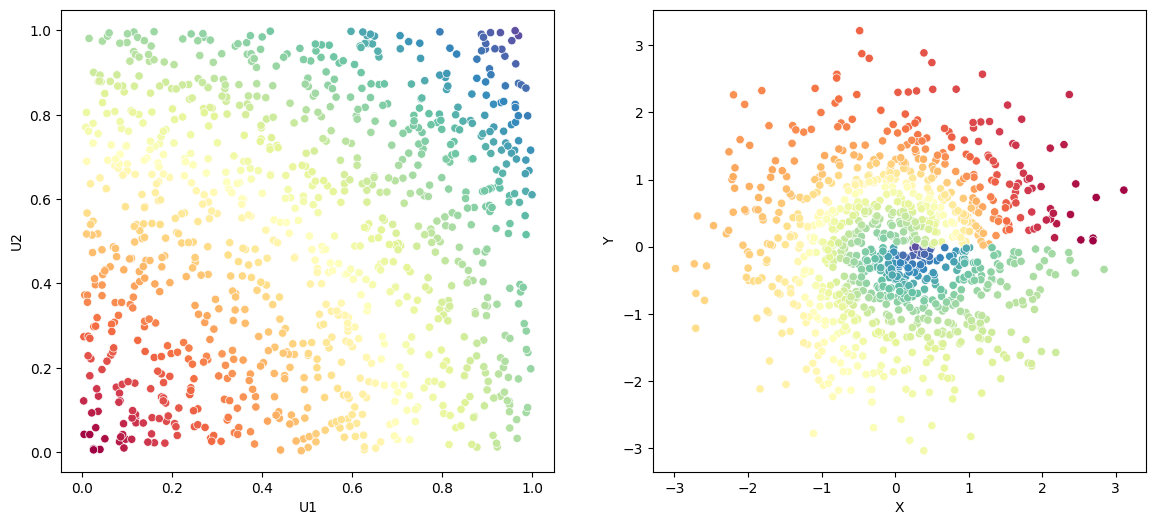

In [5]:
color = np.sqrt(u1 * u1 + u2 * u2)  # for visualization
color = color / color.max()
data["color"] = color

f, ax = plt.subplots(1, 2, figsize=(14, 6))

cmap = sns.color_palette("Spectral", as_cmap=True)
sns.scatterplot(
    data=data,
    x="U1",
    y="U2",
    hue="color",
    palette=cmap,
    ax=ax[0],
    legend=False,
)
sns.scatterplot(
    data=data, x="X", y="Y", hue="color", palette=cmap, ax=ax[1], legend=False
)
plt.show()

Что делать, если нам хочется сгенерировать объекты не в стандартном нормальном распределении, а в каком-то более сложном? В общем случае нам необходимо подобрать некоторую функцию, которая будет отображать объекты из известного "простого" распределения в "целевое". Осуществляющие такое преобразование функции будем называть **генеративными моделями**.

Если целевое распределение $\mathcal{F}[\vec {x}]$ известно аналитически, то для подбора такой функции можно воспользоваться различными модификациями алгоритма [Markov Chain Monte Carlo 📚[wiki]](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

# Генеративные алгоритмы, основанные на глубоком обучении

[[video] 📺 Behind the Scenes of GANs, VAEs and Flow-based Generative Models](https://youtu.be/szQHWHNVv18?si=tNUAFkFp9TdyUZdx)

Существует четыре основных типа алгоритмов генерации, основанных на глубоком обучении:
* **VAE** — был подробно рассмотрен на предыдущей лекции,
* **GAN** и **диффузионные модели** — мы рассмотрим сегодня,
* **flow-based** модели — с ними можно ознакомиться [самостоятельно ✏️[blog]](https://lilianweng.github.io/posts/2018-10-13-flow-models/).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/deep_generative_models.png" width="700"></center>

# Введение  в генеративно-состязательные нейронные сети GAN

[[demo] 🎮 Множество примеров различных генераторов GAN](https://thisxdoesnotexist.com)


## Вход модели (latent space)

В качестве входа модели используют **вектор независимых случайных величин**.

Входной вектор можно рассматривать как **признаки генерируемых объектов**. Если мы будем передавать только одно случайное число, то генерация будет однообразной. Чем больше признаков (степеней свободы) у входного вектора, тем потенциально разнообразнее может быть результат генерации.

Пространство, из которого семплируются входные векторы, называется **latent space** — так же, как и скрытое пространство в автоэнкодерах.

Нужно понимать различие: в автоэнкодерах распределение векторов в скрытом пространстве формируется энкодером (хотя мы можем управлять им с помощью регуляризации), а в GAN и диффузионных моделях — задается фиксированным. Поэтому в литературе также встречается вариант "predefined latent space".

### Распределение векторов в латентном пространстве

Как мы уже знаем, инициализация весов и нормализация входных данных улучшают сходимость обучения. Поэтому для латентного пространства обычно используют **многомерное стандартное нормальное распределение**:

$$Z \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

Можно рассчитывать, что после обучения при перемещении по латентному пространству свойства генерируемых объектов будут плавно меняться.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/input_latent_space_lin_interpol.png" width="400"></center>



<center><em>Линейные интерполяции между четырьмя изображениями в латентном пространстве</em></center>

<center><em>Source: <a href="https://arxiv.org/abs/1803.09093">Comparing Generative Adversarial Network Techniques for Image Creation and Modification (M. Pieters, M. Wiering, 2018)</a></em></center>

## Наивный подход в решении задачи генерации

В этой лекции мы будем использовать `lightning` для обучения и `tbparse` для визуализации логов.

In [6]:
from IPython.display import clear_output

!pip install -q torchmetrics[image]
!pip install -q lightning==2.5.0 tbparse

clear_output()

Чтобы обеспечить воспроизводимость примеров, зафиксируем начальные значения генераторов случайных чисел:

In [7]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

Попробуем собрать **генератор точек неизвестной функции**. В качестве функции будем использовать **параболу**. Для начала напишем код, который будет создавать **истинные точки**:

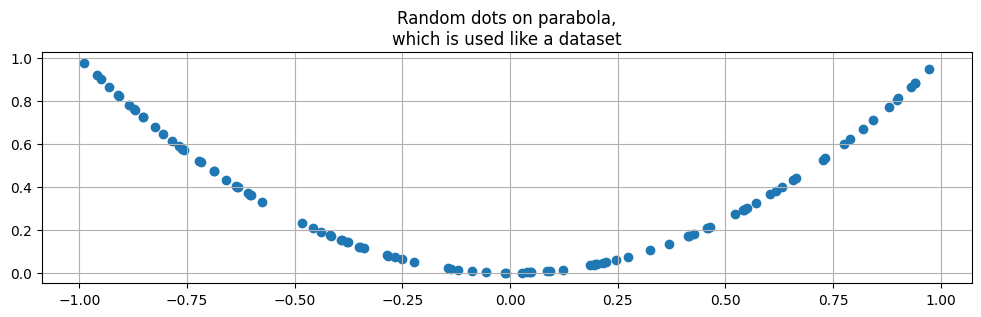

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def create_pair(num=100):
    x = np.random.uniform(low=-1, high=1, size=(num,))
    y = x * x
    return np.hstack(
        (x.reshape(-1, 1), y.reshape(-1, 1))
    )  # Create num of correct dots(x,y) on parabola


pairs = create_pair(100)
plt.figure(figsize=(12, 3))
plt.scatter(pairs[:, 0], pairs[:, 1])
plt.grid()
plt.title("Random dots on parabola,\nwhich is used like a dataset")
plt.show()

Напишем датасет, который будет выдавать случайный шумовой вектор входного латентного пространства размерностью `ls = 1` и истинные объекты.
Мы заранее создаем в функции  `__init__` точки, которые будем считать истинными.

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset


# Define input parameters
n_batches = 30
batch_size = 128
ls = 1  # latent space


class ParabolaDS(Dataset):
    def __init__(self, n_batches, batch_size, ls):
        # create ground true item
        self.xy_pair = torch.tensor(
            create_pair(num=(n_batches * batch_size)), dtype=torch.float
        )
        self.ls = ls

    def __len__(self):
        return self.xy_pair.shape[0]

    def __getitem__(self, idx):
        # get ground true item
        item = self.xy_pair[idx]
        # generate random noise
        noise = torch.randn(self.ls, dtype=torch.float)
        return item, noise


trainset = ParabolaDS(n_batches, batch_size, ls)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Определим простую модель, которая будет ожидать шум на входе и генерировать точки на выходе. Обратите внимание, что функция активации на последнем слое отсутствует, поскольку мы не ограничиваем наш генератор каким-то диапазоном.

In [10]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_space, hidden_dim=50):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )  # x,y

    def forward(self, x):
        return self.model(x)

Напишем функцию для оценки качества работы модели.

Так как мы не знаем, в каком месте параболы генератор создаст новую точку, то непонятно, с каким элементом из датасета ее сравнивать.

**Вариант №1 (связь переменных)**

Для сгенерированного $x$ аналитически вычислять $y_{\text{target}}=x*x$ и считать разницу между $y$, сгенерированным моделью, и $y_{\text{target}}$, вычисленным аналитически:

In [11]:
def custom_loss(pair, label):
    # All inputs are batches
    x_fake = pair[:, 0]
    y_fake = pair[:, 1]
    return torch.abs(x_fake * x_fake - y_fake).mean()  # average by batch

В таком случае мы вносим ограничение на связь x и y, но никак не требуем разнообразие генерации. Если модель научиться выводить точку (0, 0) - этого будет достаточно, чтобы loss достиг минимального значения.

**Вариант №2 (как не надо делать)**

Найти в датасете точку  $ \text{target} = (x_{\text{target}},y_{\text{target}})$, наиболее близкую к созданной генератором $ \text{generated} = (x,y)$, и использовать расстояние между этими точками в качестве функции потерь.

$$\large \text{Loss} = \min(\text{dist}(\text{target}_{i},\text{generated}))$$


**В пространстве высокой размерности** такой поиск будет весьма **ресурсозатратным**, но в нашем учебном примере работать будет.


In [12]:
class Loss(nn.Module):
    def __init__(self, targets):
        super().__init__()
        self.targets = targets  # Remember all real samples, impossible in real world

    def forward(self, input, dummy_target=None):
        dist = torch.cdist(input, self.targets)  # calculate pairwise distances (euc.)
        min_dist, index = torch.min(dist, dim=1)  # take the best
        return min_dist.mean()

Основной код обучения:

In [13]:
import lightning as L

# DON'T USE IT! IT'S NAIVE SOLUTION!


class NaiveGeneration(L.LightningModule):
    def __init__(self, model, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion

    def configure_optimizers(self):
        self.criterion.targets = self.criterion.targets.to(
            self.device
        )  # for fix device diff
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        real_items, noises = batch
        gen_items = self.model(noises)
        loss = self.criterion(gen_items, real_items)
        self.log("loss/train", loss, on_epoch=True, on_step=False)
        return loss

Целевые точки из датасета запоминаются в `loss`, затем идет обычный цикл обучения:

In [14]:
!mkdir log_naive/
!mkdir log_naive/lightning_logs

In [15]:
num_epochs = 10

criterion = Loss(trainset.xy_pair)  # save target
model = Generator(latent_space=ls)

pl_model = NaiveGeneration(model, criterion)
trainer = L.Trainer(
    max_epochs=num_epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log_naive/"),
    log_every_n_steps=10,
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | Generator | 2.8 K  | train
1 | criterion | Loss      | 0      | train
------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Посмотрим, куда были сохранены логи:

In [16]:
log_dir = pl_model.logger.log_dir
log_dir

'./log_naive/lightning_logs/version_0'

Визуализируем кривую обучения, чтобы удостовериться, что модель учится:

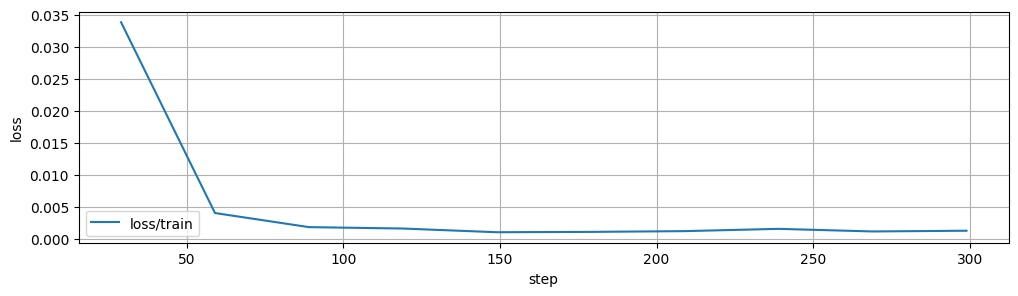

In [17]:
from tbparse import SummaryReader
from IPython.display import clear_output


def tbparse_visual(log_dir, figsize=(12, 3)):
    # Visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars

    plt.figure(figsize=figsize)
    for tag in df.tag.unique():
        if "loss" in tag:
            tag_data = df.query("`tag` == @tag").sort_values(by="step")
            plt.plot(tag_data.step, tag_data.value, label=tag)
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


tbparse_visual(log_dir)

Посмотрим результаты генерации на шуме:

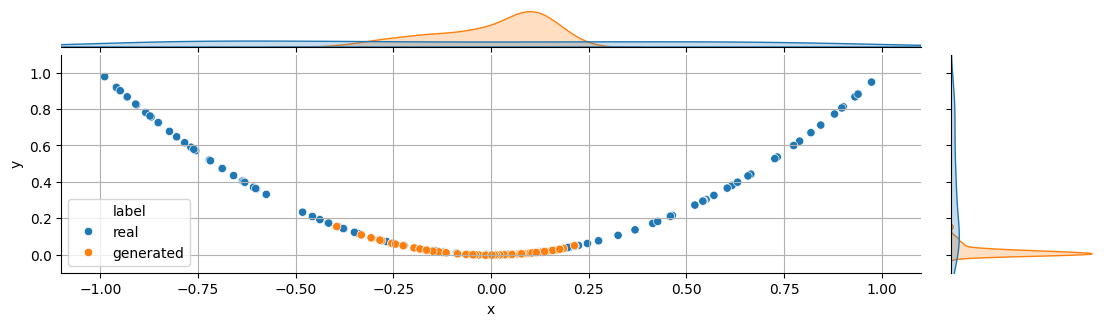

In [18]:
import pandas as pd
import seaborn as sns


def test_image(pair_gen, pairs, figsize=(12, 3)):
    # Equalizing lengths for better visualization
    if len(pair_gen) > len(pairs):
        pair_gen = pair_gen[: len(pairs)]
    else:
        pairs = pairs[: len(pair_gen)]

    df = pd.DataFrame(data=np.concatenate([pairs, pair_gen]), columns=["x", "y"])
    df["label"] = ["real"] * len(pairs) + ["generated"] * len(pair_gen)

    plot = sns.jointplot(data=df, x="x", y="y", hue="label")
    sns.move_legend(plot.ax_joint, "lower left")
    if figsize:
        plot.fig.set_size_inches(figsize)
    plt.axis([-1.1, 1.1, -0.1, 1.1])
    plt.grid()
    plt.show()


model.eval().to("cpu")
noise = torch.tensor(np.random.normal(size=(1000, ls)), dtype=torch.float)
with torch.no_grad():
    pair_gen = model(noise).detach().numpy()

test_image(pair_gen, pairs, figsize=(12, 3))

Видно, что модель генерирует точки, лежащие на параболе, но при этом видно, что **распределение сгенерированных точек существенно отличается от распределения реальных точек**. Сгенерированные точки лежат в небольшом интервале около $0$. Это можно объяснить тем, что значения ошибок около нуля в среднем меньше, ведь $y$ около $0$ принимает небольшой диапазон значений.

В функции потерь мы прописали, что сгенерированная точка должна лежать на параболе, и модель обучилась. Но информацию о том, что **генератор должен повторять распределение реальных данных**, мы в функции потерь никак не кодировали. Более того, модель может научиться хорошо генерировать одну единственную точку, и при этом функция потерь может стать нулевой.

Кроме того, для расчета функции потерь сейчас необходимо **хранить все известные точки**. Если бы мы генерировали не точки, а изображения или спектры, мы бы получили **переполнение оперативной памяти**.

Итак, надо решить **две проблемы**:
1.   Закодировать в функции потерь условие о том, что **точки должны быть различными**.
2.   Придумать способ проверки, **не требующий хранения и перебора всего датасета**.

## Дискриминатор

Будем наказывать нейронную сеть не с помощью функционала ошибок , а второй
**сетью**, которая будет определять, лежит ли сгенерированная точка на параболе.

Создадим сеть-классификатор точек, которую назовём **дискриминатор**.

В общем случае задача дискриминатора — определять, **принадлежит ли объект к распределению обучающей выборки**. Если предсказания генератора выродятся в одно значение, дискриминатор легко запомнит, что эти точки — сгенерированные.


**Итого** мы имеем:
- **генератор**, выдающий точки, которые могут принадлежать параболе, а могут не принадлежать ей;
- **дискриминатор**, который будет их различать.

Мы будем подавать в **дискриминатор** **реальные точки**, помечая их реальными,  и **точки, которые выдаёт генератор**, считая их подделкой. **Генератор** будет учиться **подражать** реальным данным, а дискриминатор будет учиться **отличать** реальные точки, от подделок.

Мы пришли к идее **генеративно-состязательных** нейронных сетей (Generative Adversarial Network).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/generative_adversarial_network_scheme.png" width="800"></center>
<center><em>Схематичное представление архитектуры GAN </em></center>

В нашем примере с генерацией точек на плоскости в качестве дискриминатора может быть использована полносвязная нейронная сеть с парой скрытых слоев, которая принимает на вход $2$ числа — координаты точки, и выдает одно число — оценку вероятности, что поданная на вход точка принадлежит распределению реальных данных.

In [19]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # real/fake
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

##  Generative adversarial network (GAN)

**Генеративно-состязательные** сети были предложены Ианом Гудфеллоу в работе [Generative Adversarial Networks (Goodfellow et al., 2014) 🎓[arxiv]](https://arxiv.org/abs/1406.2661) (**Cited by 62647 (декабрь 2023)**). Принцип состязательности в сети GAN часто объясняют на примере из теории игр.

Полезное:
* [[video] 📺 Разбор оригинальной статьи GAN](https://www.youtube.com/watch?v=eyxmSmjmNS0)
* [[video] 📺 Лекция Иана Гудфеллоу](https://www.youtube.com/watch?v=HGYYEUSm-0Q)

### GAN в теории игр

Математически можно описать идею GAN как [**игру** 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D0%B8%D0%B3%D1%80) **двух игроков**:

- Первый игрок — это **фальшивомонетчик** или генератор (generator).
- Второй — это **банкир** с машинкой для проверки денег или дискриминатор (discriminator).

Задача фальшивомонетчика — обмануть банкира. Задача банкира — отличить реальные деньги от фальшивых.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/gan_idea.png" width="600"></center>





Фальшивомонетчику необходим элемент случайности $z$.

Можно привести аналогию: если все фальшивые купюры будут иметь одинаковый номер, банкиру будет очень просто определить подделку.

Фальшивомонетчик берет на вход шум $z$ и генерирует фальшивую пачку денег $G(z)$.



Банкир получает на вход пачку купюр $x$, проверяет их подлинность и сообщает вектор $D(x)$, состоящий из чисел от нуля до единицы — свою уверенность (вероятность) по каждой купюре в том, что она настоящая.

**Цель банкира (дискриминатора):** отличить реальные деньги от фальшивых

$$D(x) = 1,  \text{ для }  x - \text{real},$$

$$D(G(z)) = 0, \text{ для } G(z) - \text{ fake},$$

то есть максимизировать $\log(D(x))+\log(1-D(G(z)))$.

**Цель фальшивомонетчика (генератора):** убедить банкира в том, что подделки настоящие

$$D(G(z)) = 1, \text{ для } G(z) - \text{ fake},$$

то есть минимизировать $\log(1-D(G(z)))$.



Математически это можно записать так:

$$\large \min\limits_{\theta_g}  \max\limits_{\theta_d} \left(\mathbb{E}_{x \sim p(x)} \left[\log\left(D_{\theta_d}(x)\right)\right]+\mathbb{E}_{z \sim p(z)}
\left[\log\left(1-D_{\theta_d}\left(G_{\theta_g}(z)\right)\right)\right]\right),$$

где $\theta_g$ — параметры генератора, $\theta_d$ — параметры дискриминатора, $p(x)$ — распределение вероятностей целевых объектов, $p(z)$ — распределение вероятностей входного шума.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/gan_probability_learning_process.png" width="1000"></center>

<center><em>Процесс обучения GAN. (a) — начало обучения, распределение сгенерированных объектов не совпадает с распределением реальных объектов, (b)&nbsp;—&nbsp;результат шага обучения, распределение сгенерированных объектов приближается к распределению реальных объектов, (c) — идеальный результат в конце обучения: полное совпадение распределений (на практике почти недостижим). </em></center>
<center><em>
Замечание: в данном случае для простоты восприятия и визуализации входной шум имеет равномерное распределение (на практике чаще используется нормальное), а распределение реальных объектов имеет нормальное распределение (на практике — сложное неизвестное распределение).</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1406.2661.pdf">Generative Adversarial Nets (Ian J. Goodfellow and all, 2014)</a></em></center>

**Дискриминатор (банкир):**
- обучается при **фиксированном генераторе** ${G}_{\theta_{g}}$,
- **максимизирует** функцию выше относительно $\theta_d$ (**градиентный подъем**),
- решает задачу **бинарной классификации**: старается присвоить $1$ точкам данных из обучающего набора $x\sim p(x)$ и $0$ сгенерированным точкам $G(z), z\sim p(z)$.

**Генератор (фальшивомонетчик):**
- обучается при **фиксированном дискриминаторе** $D_{θ_d}$,
- получает градиенты весов за счет **обратного распространения ошибки** через дискриминатор,
- **минимизирует** функцию выше относительно $\theta_g$ (**градиентный спуск**).

В процессе совместного конкурентного обучения, если система достаточно сбалансирована, достигается **минимаксное состояние равновесия**, в котором обе сети эффективно учатся.


### GAN Практический пример

Определим наши **генератор** и **дискриминатор**:

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_space, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )  # x,y

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # real/fake
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

Обратите внимание, что у нас так же, как и в первом примере, есть переменная **latent space**. Это тот шум, из которого мы будем генерировать наши точки.

**Дискриминатор** решает задачу **бинарной классификации**. Для этой задачи хорошо подходит `BCELoss` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) (**Binary Cross-Entropy**).

<font size="4">**Процесс обучения GAN**</font>

<font size="4">**Фаза 1. Обучение дискриминатора**</font>

1. Расчет градиентов дискриминатора (реальные точки):
    * обнулим градиенты **дискриминатора**,
    * возьмем набор **реальных точек**, которые лежат на параболе,
    * применим к ним **дискриминатор**,
    * посчитаем значение функции потерь дискриминатора на **реальных точках** при **метках реальных данных** `loss_disc_real`,
    * посчитаем градиенты для **дискриминатора**.



<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/gan_training_algorithm_1.png" width="1000"></center>

По аналогии с игрой: в этот момент банкир изучает **реальные купюры**, чтобы усовершенствовать машинку для проверки денег.

2. Расчет градиентов дискриминатора (сгенерированные точки):
    * возьмем случайный шум
$z$,
    * возьмем наш **генератор** (его пока не обучаем) и создадим с его помощью **сгенерированные точки** $x=G(z)$,
    * применим к ним **дискриминатор**,
    * посчитаем значение функции потерь дискриминатора на **сгенерированных точках** при **метках сгенерированных данных** `loss_disc_fake`,
    * посчитаем градиенты для **дискриминатора** (они сложатся с уже посчитанными ранее).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/gan_training_algorithm_2.png" width="1000"></center>

По аналогии с игрой: в этот момент банкир изучает **фальшивые купюры**, чтобы усовершенствовать машинку для проверки денег.

3. Обновление весов дискриминатора
   * сделаем шаг обучения **дискриминатора** (обновим его веса),
   * **генератор** не обучается.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/gan_training_algorithm_3.png" width="1000"></center>

По аналогии с игрой: в этот момент банкир **модифицирует машинку**.

<font size="4">**Фаза 2. Обучение генератора**</font>

   * обнулим градиенты **генератора**,
   * сгенерируем случайный шум $z$,
   * создадим с помощью **генератора** набор **сгенерированных точек** $x=G(z)$,
   * посчитаем значение функции потерь дискриминатора на **сгенерированных точках** при **метках реальных данных** `loss_gen` (подмена меток),
   * посчитаем градиенты для **генератора**,
   * сделаем шаг обучения **генератора** (обновим его веса),
   * **дискриминатор** не обучается.

Обратите внимание, что вместо решения minmax задачи мы **подменяем метки**: дискриминатор получает сгенерированные объекты, но в функцию потерь передается метка реальных объектов. Это [часто применяемый трюк 🐾[git]](https://github.com/soumith/ganhacks/#2-a-modified-loss-function) при обучении GAN.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/gan_training_algorithm_4.png" width="1000"></center>

По аналогии с игрой: в руки фальшивомонетчика попадается прибор для распознавания подделок, он изучает его и учится создавать подделки, которые смогут обмануть этот прибор.

Посмотрим, как это реализуется в коде обучения:

In [21]:
class GAN(L.LightningModule):
    def __init__(
        self,
        generator,
        discriminator,
        lr=3e-4,
        betas=(0.9, 0.999),
        noise_in_place=False,
        latent_dim=10,
    ):
        super().__init__()
        self.automatic_optimization = False  # for handmade settings

        self.generator = generator
        self.discriminator = discriminator
        self.criterion = nn.BCELoss()
        self.real_label = 1.0
        self.fake_label = 0.0
        self.lr = lr
        self.betas = betas
        self.noise_in_place = noise_in_place
        self.latent_dim = latent_dim

    def configure_optimizers(self):
        opt_gen = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.lr,
            betas=self.betas,
        )
        opt_disc = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr,
            betas=self.betas,
        )
        return opt_gen, opt_disc

    def training_step(self, batch, batch_idx):
        if self.noise_in_place:  # for standart dataset
            self.real_items, _ = batch
            noises = torch.randn(
                (self.real_items.shape[0], self.latent_dim),
                dtype=torch.float32,
            ).to(self.device)
        else:
            self.real_items, noises = batch  # for handmade dataset
        opt_gen, opt_disc = self.optimizers()

        # ---------------------
        # Train discriminator
        # ---------------------
        self.discriminator.zero_grad()
        # 1. Discriminator on real items
        real_label = torch.full(
            size=(self.real_items.shape[0], 1),
            fill_value=self.real_label,
            dtype=torch.float,
        ).to(self.device)
        disc_label = self.discriminator(self.real_items)
        loss_disc_real = self.criterion(disc_label, real_label)
        loss_disc_real.backward()

        # 2. Discriminator on fake items
        fake_label = torch.full(
            size=(self.real_items.shape[0], 1),
            fill_value=self.fake_label,
            dtype=torch.float,
        ).to(self.device)
        self.fake_items = self.generator(noises)
        disc_label = self.discriminator(self.fake_items)
        loss_disc_fake = self.criterion(disc_label, fake_label)
        loss_disc_fake.backward()

        # 3. Discriminator optimizer step (on real and fake items)
        opt_disc.step()
        loss_disc = 0.5 * loss_disc_real + 0.5 * loss_disc_fake
        self.log("loss/disc", loss_disc, on_epoch=False, on_step=True)

        # ---------------------
        # Train generator
        # ---------------------
        self.generator.zero_grad()
        self.fake_items = self.generator(noises)
        disc_label = self.discriminator(self.fake_items)
        loss_gen = self.criterion(disc_label, real_label)  # flip label
        loss_gen.backward()

        opt_gen.step()
        self.log("loss/gen", loss_gen, on_epoch=False, on_step=True)

        if (batch_idx + 1) % 10000 == 0:
            tbparse_visual(self.logger.log_dir)
            test_image(
                self.fake_items.detach().cpu().numpy(),
                self.real_items.detach().cpu().numpy(),
            )

    def on_train_epoch_end(self):
        tbparse_visual(self.logger.log_dir)
        test_image(
            self.fake_items.detach().cpu().numpy(),
            self.real_items.detach().cpu().numpy(),
        )

Определим **входные параметры**. Для обучения GAN нужно много реальных объетов.

In [22]:
latent_dim = 10  # latent space
num_epochs = 1
n_batches = 10000
batch_size = 512

Создадим модели:

In [23]:
set_random_seed(42)
trainset = ParabolaDS(n_batches, batch_size, latent_dim)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

generator = Generator(latent_space=latent_dim, hidden_dim=50)
discriminator = Discriminator(hidden_dim=50)

pl_model = GAN(generator, discriminator)

Обучим наш GAN:

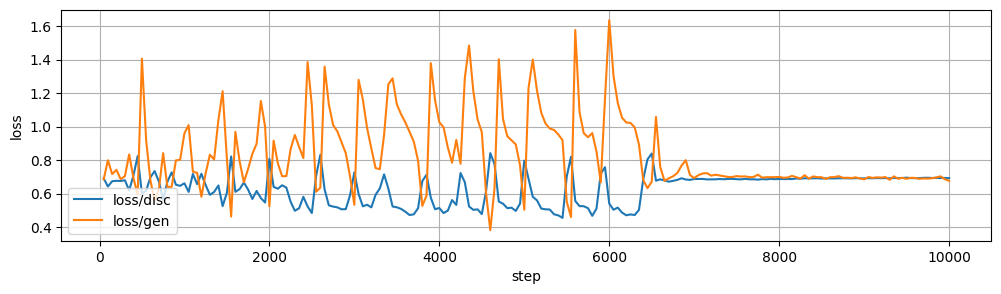

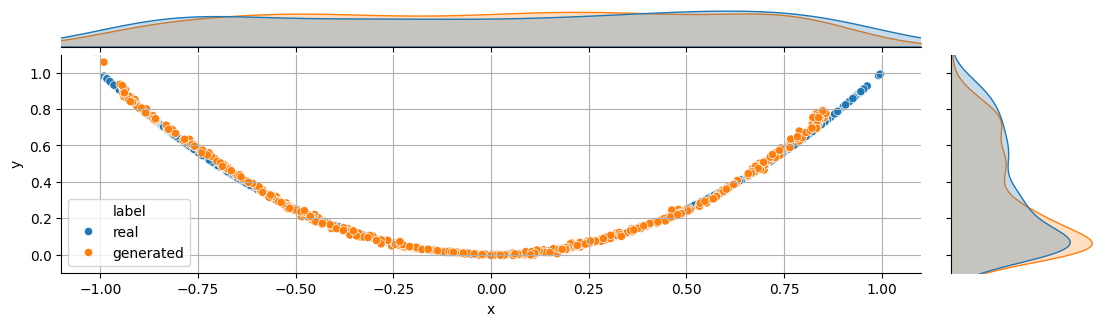

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [24]:
pl_model = GAN(generator, discriminator)
trainer = L.Trainer(
    max_epochs=num_epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log_gan/"),
)

trainer.fit(model=pl_model, train_dataloaders=train_loader)

У нас получилось сгенерировать точки, равномерно распределенные по параболе.

Посмотрим на процесс обучения GAN:

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/gan_training_process.gif" width="1000"></center>

[[colab] 🥨 Блокнот с созданием данной Gif-анимации](https://colab.research.google.com/github/Gan4x4/cv/blob/main/Generative_models/making_gan_training_process_gif.ipynb)

Видно, как графики функций потерь генератора и дискриминатора осциллируют вокруг положения равновесия, пока не встретятся в этом положении, а распределение сгенерированных данных постепенно становится все более и более похожим на распределение реальных данных.

## DCGAN — Генерация изображений

С помощью **GAN** можно генерировать не только точки на параболе, но и, например, изображения. Но появляются закономерные вопросы.

### Как из шума на входе сети получить изображение?

Самым простым ответом будет: взять шум, пропустить его через **полносвязные слои** и сделать **reshape** до нужного разрешения. В целом, это будет работать.


Однако **DCGAN (Deep Convolutional GAN)** использует **сверточные** и **сверточно-транспонированные** (*convolutional* и *convolutional-transpose*) слои в дискриминаторе и генераторе соответственно. Впервые метод **DCGAN** был описан в статье [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (Radford et al., 2015) 🎓[arxiv]](https://arxiv.org/abs/1511.06434).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/deep_convolutional_gan_scheme.png" width="900"></center>
<center><em>Схема работы DCGAN</em></center>

Ниже видна разница в генерации при помощи исключительно **полносвязных слоёв** и при помощи **обратных свёрток**. Видно, что результат **DCGAN** лучше, чем **GAN**.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/gan_dcgan_mnist_examples.png" width="600"></center>
<center><em>Сравнение результатов на MNIST (Radford et al., 2015)</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1511.06434.pdf">	Unsupervised representation learning with deep convolutional generative adversarial networks</a></em></center>

### Архитектура DCGAN

На вход генератора подают шум для создания разнообразных объектов. Этот шум представляет собой вектор в многомерном пространстве. Один вектор — один сгенерированный объект. Задача генератора — преобразовать вектор в изображение.

Такое преобразование возможно при помощи транспонированных сверточных (convolution-transpose, иногда называют fractionally strided convolution) слоев или upsample слоев с последующей сверткой.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/dcgan_architecture.png" width="900"></center>
<center><em>Зеркальная архитектура DCGAN </em></center>

### Пример обученного DCGAN

Давайте посмотрим на пример обученного **DCGAN**.

In [25]:
import torch

use_gpu = True if torch.cuda.is_available() else False

model = torch.hub.load(
    "facebookresearch/pytorch_GAN_zoo:hub",
    "DCGAN",
    pretrained=True,
    useGPU=use_gpu,
)
clear_output()

Распечатаем архитектуру генератора:

In [26]:
print(model.getNetG())

GNet(
  (formatLayer): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (main): Sequential(
    (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (convTranspose1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (convTranspose2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (convTranspose3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (outlayer): ConvTranspo

Распечатаем архитектуру дискриминатора:

In [27]:
print(model.getNetD())

DNet(
  (main): Sequential(
    (convTranspose3): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (convTranspose2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (convTranspose1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (convTranspose0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decisionLayer): Conv2d(512, 21, kern

In [28]:
import torchvision
import time


num_images = 8
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)
    generated_images = (
        generated_images.clamp(-1, 1) + 1
    ) / 2.0  # normalization to 0..1 range

del model
torch.cuda.empty_cache()

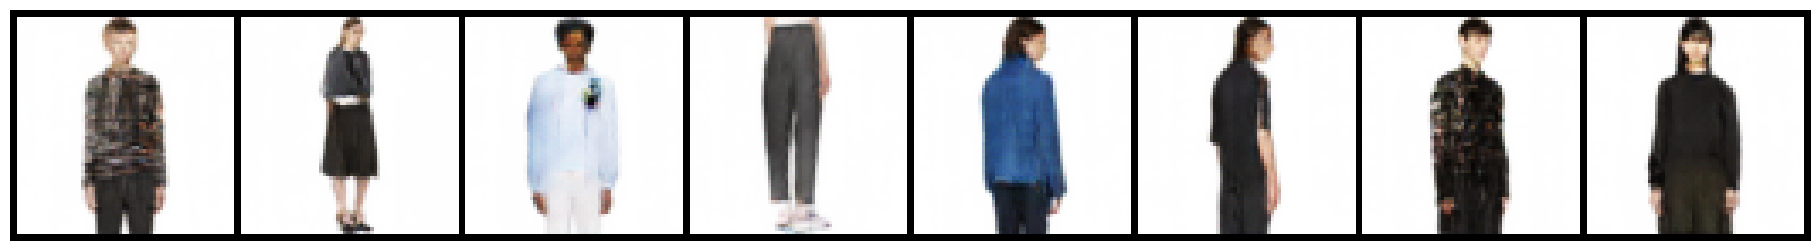

In [29]:
fig, ax = plt.subplots(figsize=(8 * 3, 1 * 3))

ax.imshow(
    torchvision.utils.make_grid(generated_images).permute(1, 2, 0).cpu().numpy(),
    interpolation="nearest",
    aspect="equal",
)
ax.axis("off")
plt.show()

### Практический пример DCGAN

Теперь давайте попробуем сами написать свой **DCGAN** и обучить его на датасете **FashionMNIST**

In [30]:
num_epochs = 3  # Num of epochs
batch_size = 64  # batch size
lr = 2e-4  # Learning rate
b1 = 0.5  # Adam: decay of first order momentum of gradient
b2 = 0.999  # Adam: decay of second order momentum of gradient
latent_dim = 100  # latent space
img_size = 32  # images size
channels = 1  # Num of channels

Обычно мы **инициализируем веса** случайным образом, но ничто не мешает нам инициализировать их так, как мы хотим. В [оригинальной статье 🎓[arxiv]](https://arxiv.org/pdf/1511.06434.pdf) про **DCGAN** предложено инициализировать веса нормальным распределением с центром в нуле и стандартным отклонением $0.02$:

In [31]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

Обратите внимание, как преобразовывается **шум** в **генераторе**:
* сначала с помощью **полносвязного слоя** он увеличивается в размере до **необходимого количества признаков**,
* потом с помощью функции `view` **форма тензора преобразуется** в **размер карты признаков на входе сверточного слоя**,
* потом при прохождении через **сверточные слои** (`conv_blocks`) к нему применяются `ConvTranspose2d`.

In [32]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(
                in_channel, out_channel, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class Generator(nn.Module):
    def __init__(self, latent_dim, img_size, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 2**2
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            GeneratorBlock(in_channel=128, out_channel=128),
            GeneratorBlock(in_channel=128, out_channel=64),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [33]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channel, out_channel, bn=True):
        super().__init__()
        block = [
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        ]
        if bn:
            block.append(nn.BatchNorm2d(out_channel, 0.8))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)


class Discriminator(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.model = nn.Sequential(
            DiscriminatorBlock(channels, 16, bn=False),
            DiscriminatorBlock(16, 32),
            DiscriminatorBlock(32, 64),
            DiscriminatorBlock(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2**4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size**2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [34]:
set_random_seed(42)
L.seed_everything(42)

# Initialize Generator and Discriminator
generator = Generator(latent_dim=latent_dim, img_size=img_size, channels=channels)
discriminator = Discriminator(channels=channels)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

pl_model = GAN(
    generator, discriminator, noise_in_place=True, latent_dim=100, lr=lr, betas=(b1, b2)
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Напишем функцию для отображения изображений:

In [35]:
from torchvision.utils import make_grid


def test_image(fake_items, real_items, figsize=(12, 3)):
    grid_fake = (
        make_grid(torch.tensor(fake_items[:10]), nrow=10, normalize=True)
        .permute(1, 2, 0)
        .numpy()
    )

    grid_real = (
        make_grid(torch.tensor(real_items[:10]), nrow=10, normalize=True)
        .permute(1, 2, 0)
        .numpy()
    )

    fig, ax = plt.subplots(2, 1, figsize=figsize)
    ax[0].imshow(grid_fake)
    ax[0].set_axis_off()
    ax[1].imshow(grid_real)
    ax[1].set_axis_off()
    plt.axis("off")
    plt.show()

Загрузим данные в `DataLoader`:

In [36]:
import os
from torchvision import datasets
from torchvision.transforms import v2

os.makedirs("../../data/mnist", exist_ok=True)

data_set = datasets.FashionMNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=v2.Compose(
        [
            v2.Resize(img_size),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.5], [0.5]),
        ]
    ),
)

data_loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=True,
)
clear_output()

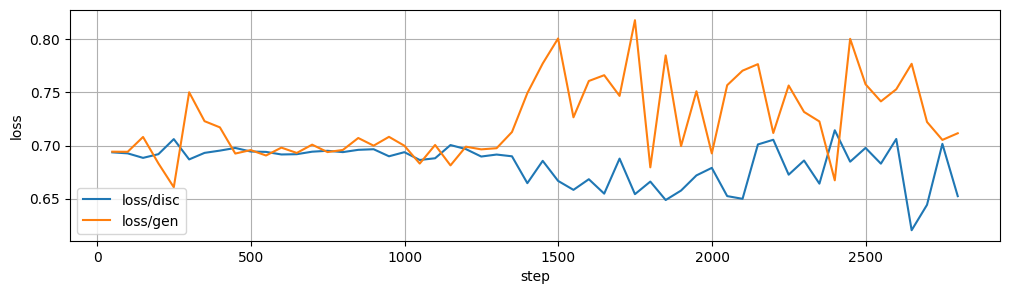

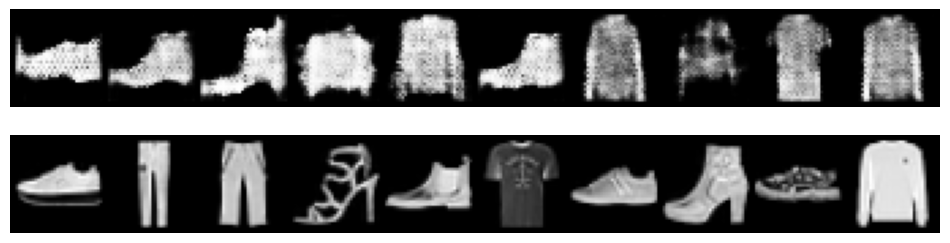

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [37]:
trainer = L.Trainer(
    max_epochs=num_epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log_cgan/"),
)

trainer.fit(model=pl_model, train_dataloaders=data_loader)

Мы проучили модель 3 эпохи. Видно, что функции потерь генератора и дискриминатора не только не сошлись, но начали расходиться. При этом на сгенерированных изображениях присутствует характерная рябь. Если увеличить количество эпох, качество генерируемых изображений улучшится, но эффект расхождения функций потерь только усилится.

Такая ситуация происходит чаще, чем нам бы хотелось. Ниже показаны кривые обучения простого GAN на датасете MNIST.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/gan_loss.png" width="600"></center>

<center><em>Кривые обучения простого GAN на датасете MNIST</em></center>

<center><em>Source: <a href="https://github.com/znxlwm/pytorch-generative-model-collections"> Pytorch implementation of various GANs</a></em></center>

## Тонкости обучения GAN

[[blog] ✏️ Детальный разбор тонкостей и советов](https://beckham.nz/2021/06/28/training-gans.html)

### Проблема больших градиентов

Одной из причин проблем со сходимостью GAN являются большие градиенты дискриминатора, которые приводят к сбою настроек генератора.

В статье [Wasserstein GAN 🎓[arxiv]](https://arxiv.org/pdf/1701.07875.pdf) показано, что обеспечение плавности ([k-Липшицевости 📚[wiki]](https://en.wikipedia.org/wiki/Lipschitz_continuity)) изменения параметров дискриминатора улучшает сходимость GAN. Есть несколько подходов к обеспечению такой плавности. Ниже приведем некоторые из них.

- Регуляризация:
    - **Weight clipping** — клиппинг (ограничение максимального и минимального значений) весов. Может давать [чрезмерно сильную регуляризацию ✏️[blog]](https://beckham.nz/2021/06/28/training-gans.html).
    - **Gradient penalty** — штраф за слишком большой или слишком маленький градиент (оптимальным выбран градиент с единичной нормой). [Cтатья 🎓[arxiv]](https://arxiv.org/pdf/1704.00028.pdf). [Код 🐾[git]](https://github.com/EmilienDupont/wgan-gp). Вычислительно сложная операция.
    - Спектральная нормализация. Вычислительно дешевый [аналог gradient penalty ✏️[blog]](https://beckham.nz/2021/06/28/training-gans.html). [Cтатья 🎓[arxiv]](https://arxiv.org/pdf/1802.05957.pdf). Код — ниже.
- Изменение функции потерь:
    - Замена Cross-Entropy Loss на [**расстояние Вассерштейна** 📚[wiki]](https://en.wikipedia.org/wiki/Wasserstein_metric) —  уход от неограниченно больших градиентов при уверенности дискриминатора, что сгенерированный объект — фейк. Применяется совместно с **weight clipping** или **gradient penalty**. [Cтатья 🎓[arxiv]](https://arxiv.org/pdf/1701.07875.pdf). [Реализация 🐾[git]](https://github.com/znxlwm/pytorch-generative-model-collections/blob/master/WGAN.py).
    - Переход на сравнение статистик карт признаков.  [Cтатья 🎓[article]](https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf). [Реализация 🐾[git]](https://github.com/openai/improved-gan).

- **Top-k Training:** отказ от обучения на плохих примерах. Градиент пропускается только через top-k наилучшим способом сгенерированных объектов. Объекты с большими градиентами отбрасываются. [Cтатья 🎓[arxiv]](https://arxiv.org/abs/2002.06224).


Ни один из этих методов не является универсальным.
Мы попробуем применить к нашей модели спектральную нормализацию:

In [38]:
from torch.nn.utils import spectral_norm


def add_spectral_norm(m):
    if isinstance(m, nn.Linear) or isinstance(m, torch.nn.Conv2d):
        m = spectral_norm(m)

In [39]:
set_random_seed(42)
L.seed_everything(42)

# Initialize Generator and Discriminator
generator = Generator(latent_dim=latent_dim, img_size=img_size, channels=channels)

discriminator = Discriminator(channels=channels)

# Initialize weight
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

discriminator.apply(add_spectral_norm)

pl_model = GAN(
    generator, discriminator, noise_in_place=True, latent_dim=100, lr=lr, betas=(b1, b2)
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


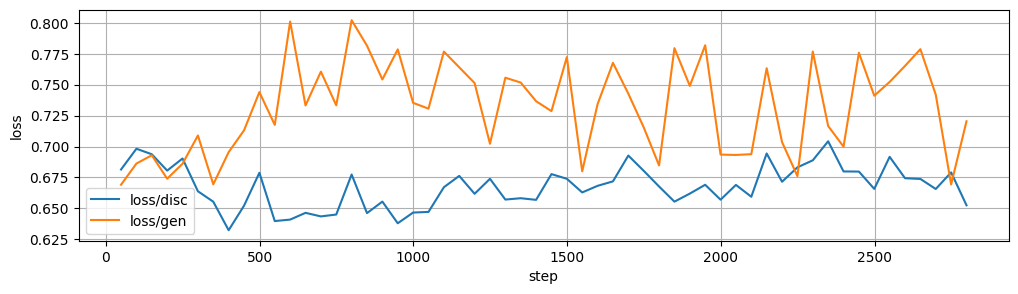

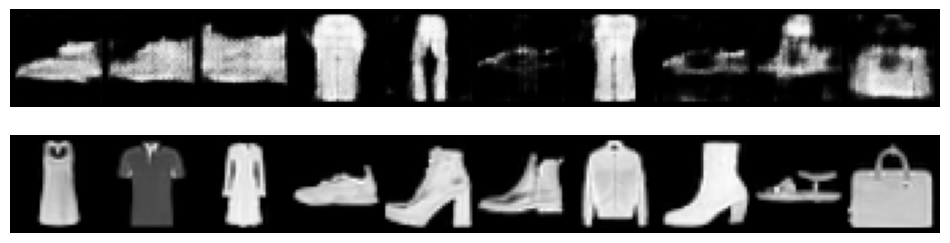

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [40]:
trainer = L.Trainer(
    max_epochs=num_epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log_cgan/"),
)

trainer.fit(model=pl_model, train_dataloaders=data_loader)

График функции потерь меняется более устойчиво. Нет ряби на изображениях. При увеличении количества эпох качество станет еще лучше.

### Другие особенности

[[git] 🐾 How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks/)

**Простые ошибки**:
- Обратите внимание, что сгенерированные объекты должны быть в том же числовом диапазоне и иметь тот же размер, что и реальные данные.
- При использовании `BatchNorm` следите, чтобы  real и fake батчи [поступали на дискриминатор отдельно 🐾[git]](https://github.com/soumith/ganhacks/?tab=readme-ov-file#4-batchnorm). При небольшом количестве объектов в батче или странном поведении модели в тестовом режиме лучше использовать `InstanceNorm`.

**Нужно ли давать преимущество дискриминатору?**

Один из самых старых и распространенных советов при обучении GAN — давать преимущество дискриминатору. Это означает, например, что параметры дискриминатора обновляются чаще, чем параметры генератора. В большинстве случаев ограничение градиентов работает не хуже, чем такая нетривиальная организация процесса обучения, а делается проще.


**Оптимизатор:**

В большинстве статей про **GAN** используется **ADAM**. В [статье 🎓[arxiv]](https://arxiv.org/pdf/1802.05957.pdf) проведено исследование по поиску оптимальных параметров оптимизатора: для большинства архитектур $\beta_1 = 0.5, \beta_2 = 0.999, \text{lr} = 2\cdot 10^{-4}$ — хорошая отправная точка для обучения.

Параметр `epsilon` **ADAM** по умолчанию в PyTorch равен `1e-8`, что может вызвать проблемы после длительного периода обучения, например, резкий рост значений функции потерь. Для борьбы с этим параметр `epsilon` можно увеличить, например, до `1e-3`. Подробнее об этом на [StackOverflow ✏️[blog]](https://stackoverflow.com/questions/42327543/adam-optimizer-goes-haywire-after-200k-batches-training-loss-grows) и в комментарии на [Reddit ✏️[blog]](https://www.reddit.com/r/reinforcementlearning/comments/j9rflf/intuitive_explanation_for_adams_epsilon_parameter/).

## Метрики генерации

Для того, чтобы улучшить генерацию, нам нужно понять, что значит лучше. Для этого нам нужно определиться с метриками. Одной из проблем генерации является **mode collapse** — ситуация, когда модель выдает одно и то же изображение или один и тот же класс и т. д., независимо от того, какие входные данные ей подаются.

Ниже представлен пример с данными, представляющими собой 8 кластеров из гауссовых распределений. Верхняя строка — успешное обучение, нижняя — mode collapse.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/mode_collapse_example.png" width="900"></center>

<center><em>Обучение  GAN на смеси двумерных гауссиан. Верхняя строка — успешное обучение, нижняя — mode collapse.</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1611.02163.pdf">Unrolled Generative Adversarial Networks</a></em></center>

Посмотрим на это с точки зрения распределений:

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/mode_collapse_in_gan.png" width="850"></center>

<center><em>Mode collapse в GAN (a) — с точки зрения распределения, (b) — с точки зрения сгенерированных изображений.</em></center>

<center><em>Source: <a href="https://www.researchgate.net/publication/354203725_Modified_generative_adversarial_networks_for_image_classification">Modified generative adversarial networks for image classification</a></em></center>

С точки зрения распределений mode collapse случается, когда модель повторяет только часть сложного распределения целевых данных.

 ### Inception Score

Для определения качества генерации мы бы хотели оценивать два свойства сгенерированной коллекции изображений:
- качество изображения: похоже ли сгенерированное изображение на какой-то конкретный объект или это шум?
- разнообразие изображений: не происходит ли mode collapse?


Один из способов проверить оба свойства — использовать **Inception Score**. **Inception Score** — это способ оценки качества генерации с использованием сети Inception-v3, обученной на ImageNet (1000 классов), предложенный в статье [Improved Techniques for Training GANs 🎓[arxiv]](https://arxiv.org/pdf/1606.03498.pdf) в 2016 году.


<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/inception_v3_architecture.png" width="900"></center>

<center><em>Архитектура Inception-v3</em></center>

<center><em>Source: <a href="https://paperswithcode.com/method/inception-v3">Rethinking the Inception Architecture for Computer Vision</a></em></center>

Оцениваемые изображения прогоняются через сеть Inception-v3. На выходе сети — вероятности для 1000 классов $p(y|x)$, где $x$ — входное изображение, $y$ — метка класса.
- Для оценки качества изображения: сгенерированное изображение должно с высокой вероятностью относиться к одному из классов. Это значит, что энтропия $p(y|x)$ должна быть низкой:

$$H = -\sum_{i}p_i\log{p_i}$$

- Для оценки разнообразия: мы хотим, чтобы предсказываемые метки классов были как можно более разнообразными. Это значит, что мы должны максимизировать энтропию $\int{p(y|x=G(z))dz}$.

Эти два условия могут быть [объединены ✏️[blog]](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/) через [дивергенцию Кульбака-Лейблера 📚[wiki]](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) в Inception Score:

$$\text{IS} = \exp(\mathbb{E}_x\text{KL}(p(y|x)||p(y)))$$

Минимальное значение $\text{IS}$ равно 1, максимальное (для Inception-v3, обученной на ImageNet) равно 1000. Чем **выше качество генерации** и больше вариативность, тем **выше Inception Score**.

Проблемы **Inception Score**:
 - Значение **Inception Score** зависит от применяемой модели Inception-v3: они могут быть написаны на различных библиотеках, обучаться с разной точностью вычислений на различных устройствах с различной инициализацией.
 - Inception-v3 обучена на ImageNet, она адекватно работает на датасетах с похожими данными, например, на тестовой выборке датасета CIFAR-10 она дает значение порядка 11, что близко к количеству исходных данных. Но для оценки, например, медицинских данных имеет смысл использовать собственный классификатор.
 - Inception-v3 обучена на 3-хканальных изображениях с размером 299×299 и может некорректно работать с другими форматами.

### Frechet Inception Distance (FID)

Более поздней [модификацией 🎓[arxiv]](https://arxiv.org/pdf/1706.08500.pdf)  Inception Score является Frechet Inception Distance. Эта метрика использует [расстояние Фреше 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%A4%D1%80%D0%B5%D1%88%D0%B5) (метрика сходства кривых) для оценки разницы между распределением высокоуровневых признаков, извлекаемых Inception-v3 для реальных и сгенерированных изображений.
Т. к. FID использует метрику расстояния, **чем меньше  FID — тем лучше**.

Эта метрика меньше привязана к ImageNet, т. к. рассматривает распределение высокоуровневых признаков, а не предсказываемых классов, но также зависит от версии библиотек.

Кроме того, у нее есть особенность: если вместо того, чтобы научиться генерировать новые изображения, модель выучит все изображения из обучающей выборки, значение FID будет очень низким, а если сравнивать с train данными — нулевым, поэтому важно сравнивать с отложенной выборкой (о чем иногда забывают).

[[git] 🐾 Другие метрики генерации](https://github.com/yhlleo/GAN-Metrics)

### Пример расчета метрик

Попробуем посчитать метрики для [предобученного на CIFAR-10 GAN 🐾[git]](https://github.com/csinva/gan-vae-pretrained-pytorch). Для этого клонируем код из репозитория.

In [41]:
!git clone -q https://github.com/csinva/gan-vae-pretrained-pytorch.git

Создадим модель (нам нужен только генератор).

In [42]:
import sys

sys.path.append("/content/gan-vae-pretrained-pytorch")

In [43]:
from cifar10_dcgan.dcgan import Generator

generator = Generator(ngpu=1)

Подгрузим веса модели:

In [44]:
import torch

generator.load_state_dict(
    torch.load(
        "/content/gan-vae-pretrained-pytorch/cifar10_dcgan/weights/netG_epoch_199.pth",
        weights_only=True,
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

Попробуем сгенерировать данные. Для этого пропишем денормализацию: автор кода использовал `mean=(0.5, 0.5, 0.5)` и `std=(0.5, 0.5, 0.5)` (не лучший выбор для CIFAR-10).

In [45]:
from torchvision.transforms import v2

batch_size = 16
nz = 100

denormalization = v2.Compose(
    [
        v2.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
        v2.Normalize(mean=[-0.5, -0.5, -0.5], std=[1.0, 1.0, 1.0]),
    ]
)

noise = torch.randn(batch_size, nz, 1, 1)
imgs = denormalization(generator(noise))
imgs = (imgs * 255).type(torch.uint8)

Посмотрим на результат генерации:

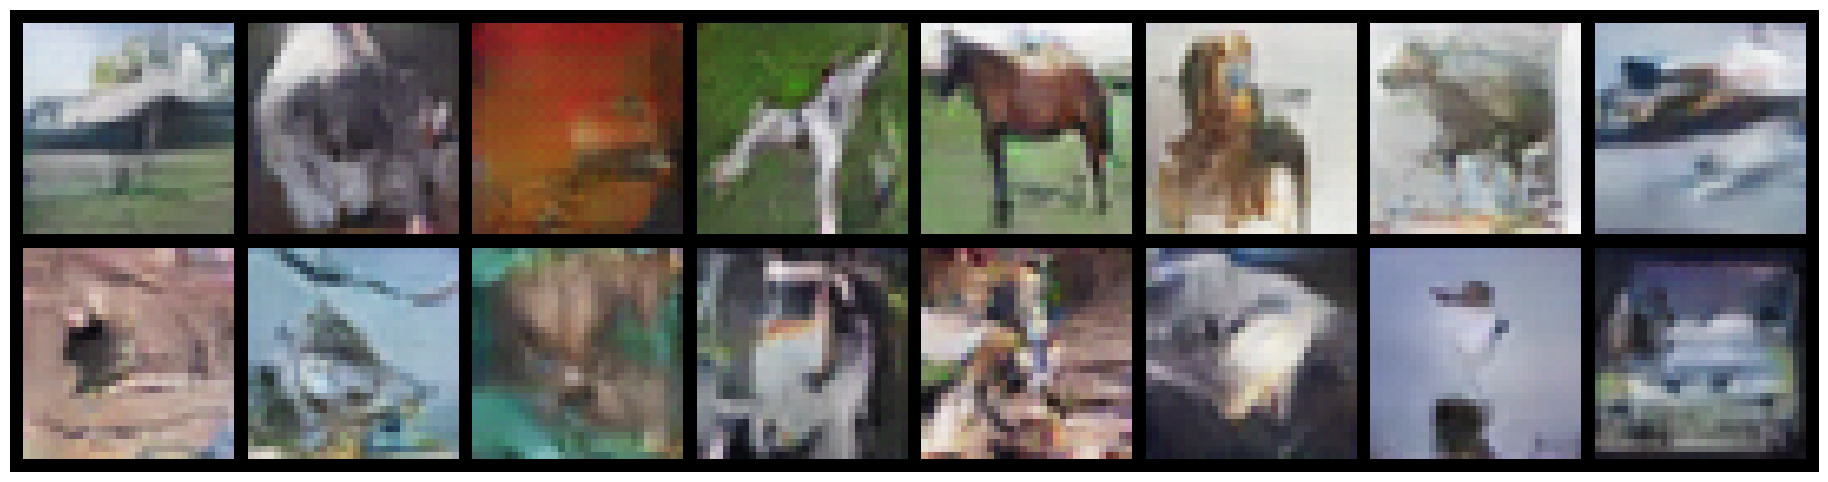

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16 * 3, 2 * 3))
ax.imshow(
    make_grid(imgs).permute(1, 2, 0).cpu().numpy(),
    interpolation="nearest",
    aspect="equal",
)
ax.axis("off")
plt.show()

Загрузим тестовый датасет от CIFAR-10:

In [47]:
from torchvision import datasets

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

test_dataset = datasets.CIFAR10(
    "content", train=False, download=True, transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=2
)

100%|██████████| 170M/170M [00:04<00:00, 34.7MB/s]


Для расчета будем использовать метрики из `torchmetrics`, для корректной работы нужно сначала установить `torchmetrics[image]`, а потом `lightning`:

In [48]:
from IPython.display import clear_output

!pip install -q torchmetrics[image]
!pip install -q lightning==2.5.0

clear_output()

 При работе с метриками генерации из `torchmetrics` есть ряд особенностей:
- `InceptionScore` и `FrechetInceptionDistance` работают с трехканальными изображениями `[batch, 3, 299, 299]` типа `torch.uint8`. Изменение размера метрика делает автоматически, а количество каналов и тип данных — наша забота.
- Параметр `feature` позволяет выбирать, из какой части модели берутся признаки. Вместо чисел туда можно передавать собственный экстрактор признаков типа `nn.Module`.
- Метрики рекомендуется использовать внутри `L.LightningModule` с включенной GPU, тогда вычисления происходят быстрее.

In [49]:
import lightning as L

from torchmetrics import MetricCollection
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance


class RunMetric(L.LightningModule):
    def __init__(self, generator, noise_gen, detransform):
        super().__init__()
        # model
        self.generator = generator
        self.noise_gen = noise_gen
        self.detransform = detransform

        # metrics
        self.is_real = InceptionScore()
        self.is_fake = InceptionScore()

        self.fid = MetricCollection(
            {
                "FID_64": FrechetInceptionDistance(feature=64),
                "FID_192": FrechetInceptionDistance(feature=192),
                "FID_768": FrechetInceptionDistance(feature=768),
                "FID_2048": FrechetInceptionDistance(feature=2048),
            }
        )

    def test_step(self, batch, batch_idx):
        real, _ = batch
        batch_size = real.shape[0]
        noise = self.noise_gen(batch_size).to(self.device)
        fake = self.generator(noise)
        fake = self.detransform(fake)

        real = (real * 255).type(torch.uint8)
        fake = (fake * 255).type(torch.uint8)

        self.fake = fake

        self.is_real.update(real)
        self.is_fake.update(fake)

        self.fid.update(real, real=True)
        self.fid.update(fake, real=False)

    def on_test_epoch_end(self):
        is_real = self.is_real.compute()[0]
        self.log("IS_real", is_real.item())
        self.is_real.reset()

        is_fake = self.is_fake.compute()[0]
        self.log("IS_fake", is_fake.item())
        self.is_fake.reset()

        fid = self.fid.compute()
        self.log_dict(fid)
        self.fid.reset()

        fig, ax = plt.subplots(figsize=(16 * 3, 2 * 3))
        ax.imshow(
            make_grid(self.fake).permute(1, 2, 0).cpu().numpy(),
            interpolation="nearest",
            aspect="equal",
        )
        ax.axis("off")
        plt.show()

In [50]:
def noise_gen(batch_size, nz=100):
    return torch.randn(batch_size, nz, 1, 1)

In [51]:
!mkdir /content/lightning_logs

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

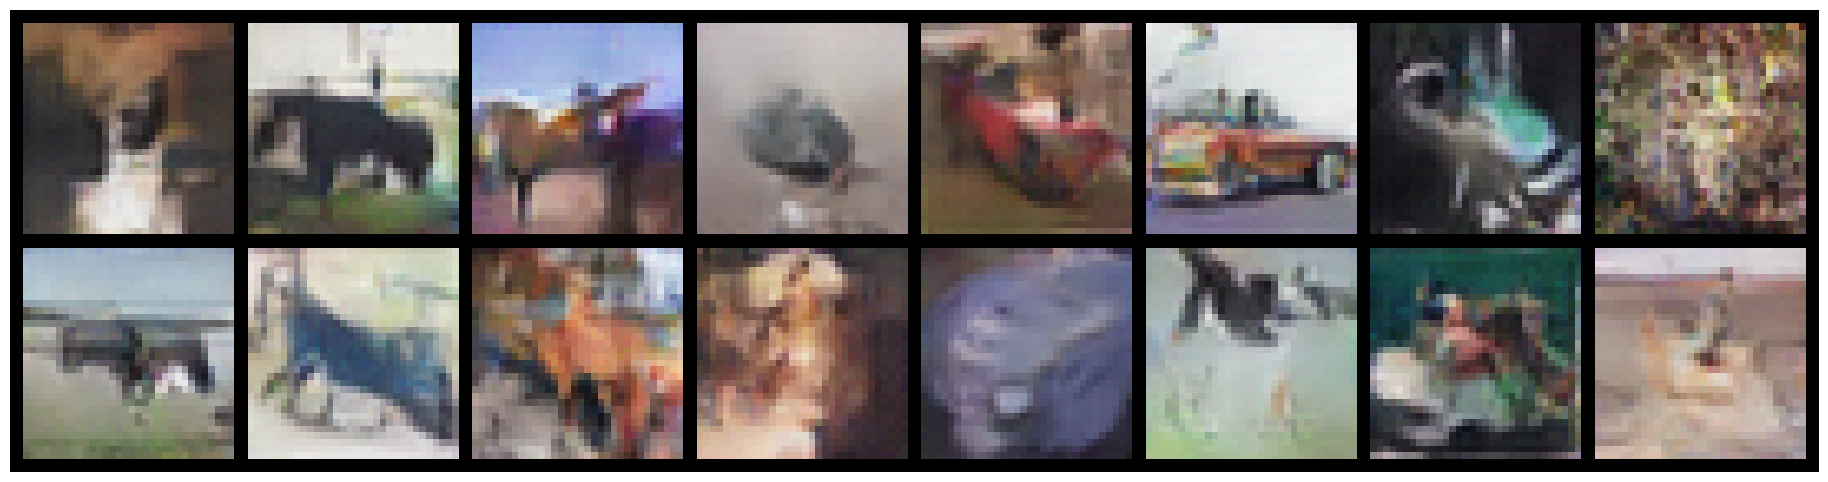

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          FID_192          │    1.6677895784378052     │
│         FID_2048          │     38.30160140991211     │
│          FID_64           │    0.2528167963027954     │
│          FID_768          │    0.2797166705131531     │
│          IS_fake          │     6.492352485656738     │
│          IS_real          │    10.979336738586426     │
└───────────────────────────┴───────────────────────────┘

In [52]:
L.seed_everything(42)

pl_model = RunMetric(generator, noise_gen, denormalization)
clear_output()
trainer = L.Trainer(max_epochs=0)
metrics = trainer.test(model=pl_model, dataloaders=test_loader)

Значение IS для тестовых данных CIFAR-10 около 11, для сгенерированных данных — 6.5. Это значит, что качеству генерации есть куда расти (по сгенерированным изображениям это видно), что касается FID — чтобы сравнить модели, нужно обучить несколько. Чем меньше FID, тем лучше.

## cGAN — GAN с условием

**cGAN** расшифровывается как **Conditional Generative Adversarial Network** — это **GAN** с условием. Условие может быть любым, например, генерация конкретной цифры. В этом случае нам нужен уже размеченный датасет для того, чтобы обучить Conditional GAN.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/conditional_gan_scheme.png" width="700"></center>
<center><em>Схема работы cGAN. Label Y добавляется к случайному шуму, тем самым мы говорим генератору генерировать случайное изображение нужного класса. Также он подаётся в дискриминатор в качестве входа, чтобы дискриминатор знал, какое изображение классифицировать как реальное, а какое — как сгенерированное.</em></center>

Обучение в данном случае будет аналогичным обучению **GAN**: мы будем обучать сети, чередуя реальные данные и сгенерированные, добавив `label`.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/cgans_results_20_and_50_epochs_mnist.png" width="600"></center>
<center><em>Сравнение результатов cGAN и cDCGAN</em></center>

<center><em>Source: <a href="https://github.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN">PyTorch Implementation of cGAN and cDCGAN</a></em></center>



### Кодирование меток классов

Поскольку подавать в сеть числа от 0 до 9 (в случае **MNIST**) нет смысла, нужно придумать, как подавать их в нейронную сеть. На помощь приходят **Embeddings**. Мы можем представить каждую метку в виде вектора из, например, 128 компонент.

[[doc] 🛠️](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) `nn.Embedding`

In [53]:
samples, labels = next(iter(data_loader))

label_emb = nn.Embedding(10, 128)

e = label_emb(labels)

print(f"Label: {labels[0]}")
print(f"Embedding for this label has shape: {e[0].shape}")

Label: 3
Embedding for this label has shape: torch.Size([128])


После этого **эмбеддинги** меток обычно конкатенируются или суммируются с входами сетей.

**Почему нельзя подать просто число?**

Если мы будем подавать просто число, например, $0.1$ для единицы и $0.5$ для пяти, то вход у нас будет непрерывным, что довольно нелогично: тогда при небольшом изменении входа мы будем генерировать другую цифру. А также сети будет сложнее выучить небольшие расхождения в этом небольшом интервале. В случае с векторным представлением мы избегаем этих проблем.

## Модификации GAN

Существует множество способов модификации GAN. Например, можно подмешивать метки классов только в дискриминатор, как сделано в [**Semi-Supervised GAN** 🎓[arxiv]](https://arxiv.org/pdf/1606.01583.pdf). В нем дискриминатор делает классификацию не на $2$ класса **[real, fake]**, а на $n+1$ класс **[real 1, real 2, …, real n, fake]**, где $n$ — количество классов в исходном датасете.

Другие модификации и пример кода с ними:
* [[git] 🐾 PyTorch Generative Model Collections](https://github.com/znxlwm/pytorch-generative-model-collections)
* [[git] 🐾 PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN).

Также стоит отметить добавление модификаций исходного латентного пространства — **Style GAN**. Именно они позволили генерировать фотореалистичные изображения с  минимальным количеством артефактов. [Примеры изображений ✏️[blog]](https://nvlabs.github.io/stylegan3/).

Статьи про модификации GAN'ов:

* [[arxiv] 🎓 A Style-Based Generator Architecture for Generative Adversarial Networks (StyleGAN) (Karras et al., 2018)](https://arxiv.org/abs/1812.04948)
* [[arxiv] 🎓 Analyzing and Improving the Image Quality of StyleGAN (StyleGAN2) (Karras et al., 2019)](https://arxiv.org/abs/1912.04958)
* [[arxiv] 🎓 Alias-Free Generative Adversarial Networks (Alias-Free GAN) (Karras et al., 2021)](https://arxiv.org/abs/2106.12423)